# Exploração inicial

* Este notebook procura explorar as variáveis disponiveis na *API Covid tracking*

Census API: https://api.census.gov/data/2019/pep/charagegroups?get=NAME,POP&for=state:*
Manual: https://www.census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf

In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
plt.style.use('ggplot')

* ## Aquisição dos dados *US Historical*

In [3]:
%run testing.py

Fetching 2 endpoints from COVID-TRACKING
[Feb 15. 02:27] Starting process.

[1/2] Endpoint: STATES-INFO -> Requesting API... Writing content

[2/2] Endpoint: US-HISTORICAL -> Requesting API... Writing content

Fetching files concluded.


In [8]:
def convert_date_to_index(df):
    df = df.assign(date = df['date'].apply(pd.Period)) \
            .set_index('date').sort_index(ascending=True) \
            .loc['jan-2020':'nov-2020']
    return df

def mse(series):
    return series.pow(2).sum().mean()
    
def missing_period(period_index):
    full_index = pd.period_range(start=period_index[0], end=period_index[-1], freq=period_index.freq)
    return ~len(full_index) == len(period_index)

In [9]:
us_hist = pd.read_pickle('./data/dataframes/us_historical.pkl') \
    .pipe(convert_date_to_index)

In [10]:
missing_period(us_hist.index)

False

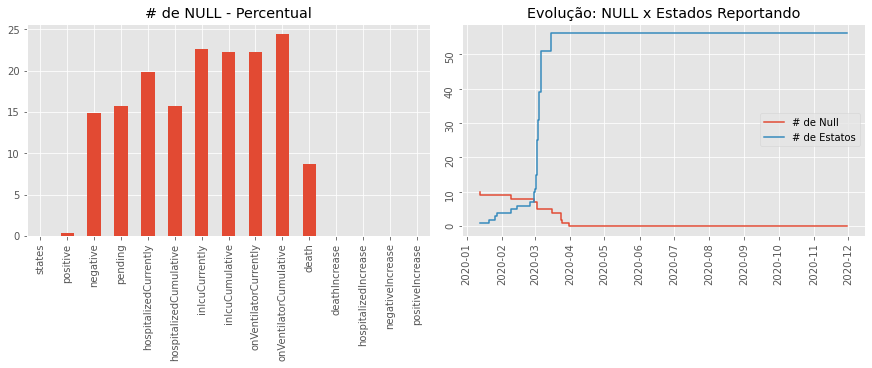

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)
us_hist.isnull().sum(axis=0).apply(lambda x: x/len(us_hist)*100).plot.bar(title='# de NULL - Percentual', ax=ax1)
us_hist.isnull().sum(axis=1).pipe(lambda s: ax2.step(s.index.to_timestamp(),s.values, label='# de Null'))
us_hist['states'].pipe(lambda s: ax2.step(s.index.to_timestamp(),s.values, label='# de Estatos'))
ax2.legend()
ax2.set_title('Evolução: NULL x Estados Reportando')
ax2.tick_params(rotation=90);

<AxesSubplot:xlabel='date'>

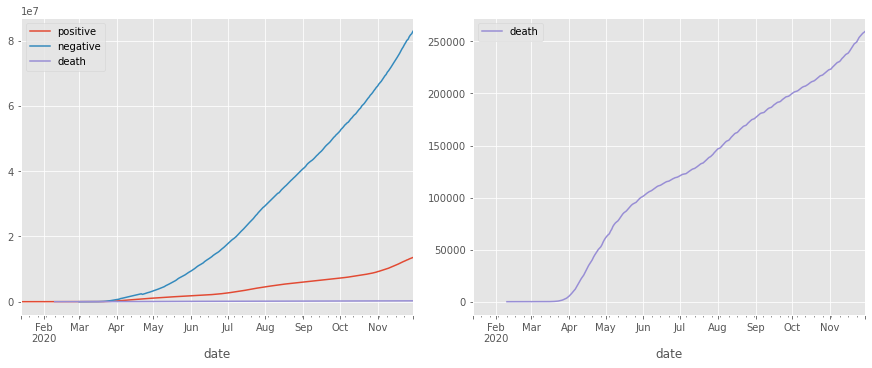

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)
us_hist[['positive', 'negative', 'death']].plot(ax=ax1)
us_hist['death'].plot(ax=ax2, color='C2', label='death', legend=True)

<AxesSubplot:xlabel='deathDiff', ylabel='deathIncrease'>

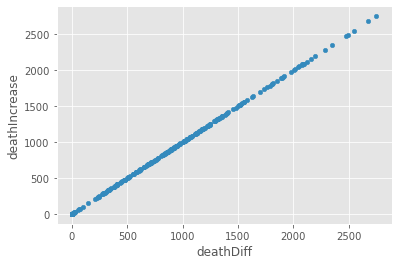

In [13]:
us_hist.assign(deathDiff = lambda df: df['death'].diff()) \
    .plot.scatter(x='deathDiff', y='deathIncrease')

<AxesSubplot:xlabel='date'>

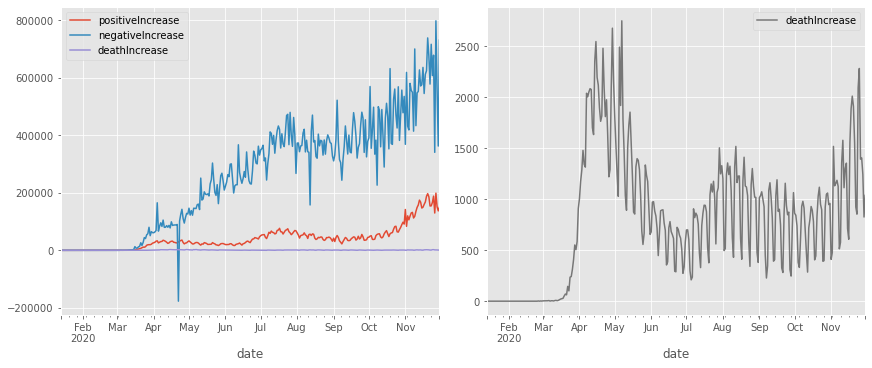

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)
us_hist[['positiveIncrease', 'negativeIncrease', 'deathIncrease']].plot(ax=ax1)
us_hist['deathIncrease'].plot(ax=ax2, color='C3', label='deathIncrease', legend=True)

<AxesSubplot:xlabel='date'>

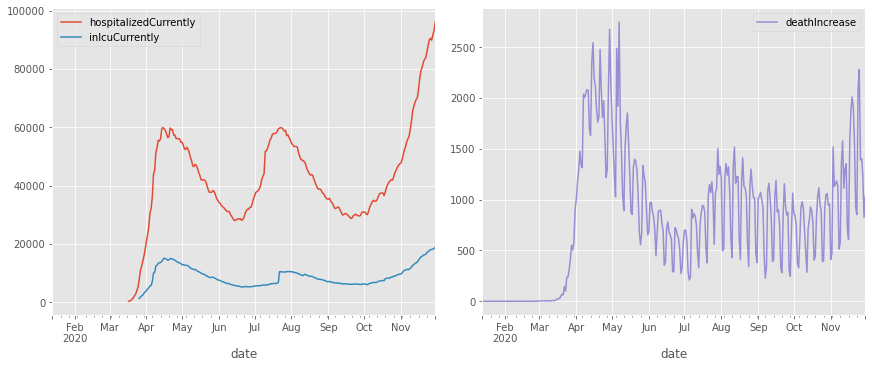

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)
us_hist[['hospitalizedCurrently', 'inIcuCurrently']].plot(ax=ax1)
us_hist['deathIncrease'].plot(ax=ax2, color='C2', label='deathIncrease', legend=True)

<AxesSubplot:xlabel='date'>

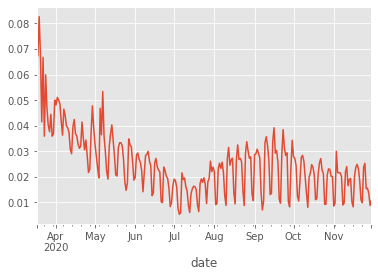

In [17]:
(us_hist['deathIncrease']/us_hist['hospitalizedCurrently']).dropna().plot()

<AxesSubplot:xlabel='date'>

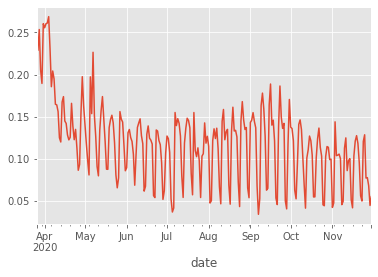

In [18]:
(us_hist['deathIncrease']/us_hist['inIcuCurrently']).dropna().plot()

In [16]:
for i in range(65):
    delay = us_hist.assign(deathDelay = lambda df: df['hospitalizedCurrently'].shift(i) - df['deathIncrease'])['deathDelay'] \
            .dropna().pipe(mse)
    print(i, delay)

0 535562227136.0
1 526546583942.0
2 518097586497.0
3 509935070154.0
4 502087196333.0
5 494105652041.0
6 486199649345.0
7 478655731014.0
8 471559438253.0
9 464859673790.0
10 458222719123.0
11 451733326471.0
12 445485945421.0
13 439412519364.0
14 433723659320.0
15 428657422604.0
16 424058950364.0
17 419521106875.0
18 415097249989.0
19 410823039171.0
20 406754094724.0
21 403123191141.0
22 399876140983.0
23 396933432976.0
24 394068377062.0
25 391286713732.0
26 388657588129.0
27 386144260233.0
28 383789054909.0
29 381669009057.0
30 379667803537.0
31 377666065181.0
32 375687347569.0
33 373750721923.0
34 371884833898.0
35 370087528159.0
36 368448791712.0
37 366932116770.0
38 365374032770.0
39 363820870632.0
40 362290749677.0
41 360799868123.0
42 359387274606.0
43 358118980322.0
44 356968080548.0
45 355731180218.0
46 354461682366.0
47 353178026540.0
48 351890311712.0
49 350681427737.0
50 349567498565.0
51 348515654648.0
52 347434479908.0
53 346310195806.0
54 345204726504.0
55 344133135782.0
56

<AxesSubplot:xlabel='date'>

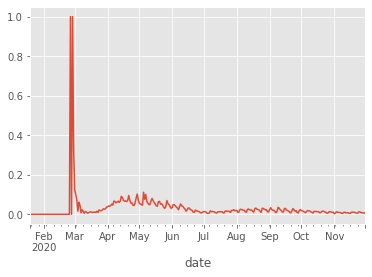

In [19]:
(us_hist['deathIncrease']/us_hist['positiveIncrease']).dropna().plot()

<AxesSubplot:xlabel='date'>

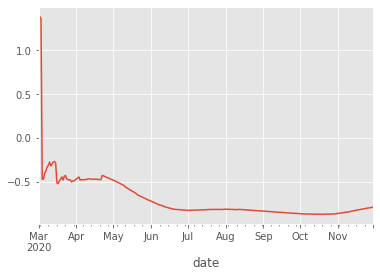

In [20]:
(us_hist['positive']/us_hist['negative']).dropna().apply(np.log10).plot()

<AxesSubplot:xlabel='date'>

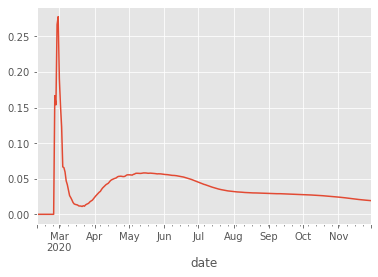

In [21]:
(us_hist['death']/us_hist['positive']).dropna().plot()